In [2]:
!pip install chess
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, FourPeaks, FlipFlopGenerator, KnapsackGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner
from A2_helpers.Four_peaks_helpers import Runner_overSeeds
import pandas as pd

# switch off the chatter
logging.basicConfig(level=logging.WARNING)

# fitness funcions list
#https://mlrose.readthedocs.io/en/stable/source/fitness.html#fitness

# about the mlrose setup
#https://mlrose.readthedocs.io/en/stable/source/tutorial1.html

# algos
# https://mlrose.readthedocs.io/en/stable/source/algorithms.html#algs

## RHC Graphs

Collect Data Ran from A2P1Collection notebook

In [56]:
#kwargs = { "iteration_list":2 ** np.arange(11), "restart_list": [5,10,20,40,80],  "experiment_name": "RHC_runner"} 
# hyperparameters above
rhc_stats_all = pd.read_csv("RunData/4peaks/4peaks_df_run_stats_total_all_problem_sizes_rhc.csv")
rhc_curves_all = pd.read_csv("RunData/4peaks/4peaks_df_run_curves_total_all_problem_sizes_rhc.csv")

In [57]:
rhc_stats_all["problem_size"] = rhc_stats_all["State"].apply(lambda x: len(literal_eval(x)))
rhc_stats_all["problem_size"]

0         10
1         10
2         10
3         10
4         10
        ... 
57595    160
57596    160
57597    160
57598    160
57599    160
Name: problem_size, Length: 57600, dtype: int64

In [58]:
rhc_stats_all


,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart,seed,problem_size
0,0,0,2.0,0,0.000112,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",5,1024,0,1,10
1,1,1,2.0,1,0.001750,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",5,1024,0,1,10
2,2,2,2.0,2,0.003381,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",5,1024,0,1,10
3,3,4,2.0,4,0.004463,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0]",5,1024,0,1,10
4,4,8,3.0,9,0.005608,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]",5,1024,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...
57595,1915,64,1.0,77617,769.549061,"[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...",80,1024,80,10,160
57596,1916,128,1.0,77681,770.888341,"[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...",80,1024,80,10,160
57597,1917,256,4.0,77811,773.387863,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...",80,1024,80,10,160
57598,1918,512,7.0,78069,778.221952,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",80,1024,80,10,160


In [59]:
rhc_stats_all.groupby('seed')['Fitness'].max()
result = rhc_stats_all.groupby(['problem_size', 'seed', 'current_restart'])['Fitness'].max().reset_index() # max fitness for each seed, restart problem size across iterations
rhc_mean = result.groupby(['problem_size', 'current_restart']).mean() # mean over the seeds 
rhc_mean.groupby(['problem_size']).max().reset_index() # max fitness for each problem size over the restarts 


,problem_size,seed,Fitness
0,10,4.166667,14.666667
1,20,4.166667,25.000000
2,40,4.166667,45.166667
3,80,4.166667,36.833333
4,160,4.166667,19.166667


In [60]:
result = rhc_stats_all.groupby(['problem_size', 'seed', 'current_restart'])['Fitness'].max().reset_index()

# Calculating the mean fitness over the seeds
rhc_mean = result.groupby(['problem_size', 'current_restart']).mean()

# Getting the max mean fitness for each problem size over the restarts
max_fitness_per_problem_size = rhc_mean.groupby(['problem_size'])['Fitness'].max().reset_index()

# Merging the max fitness per problem size with the rhc_mean to find the corresponding number of restarts
merged = rhc_mean.reset_index().merge(max_fitness_per_problem_size, on=['problem_size', 'Fitness'], how='inner')

# Selecting the required columns: problem_size and current_restart (number of restarts)
result_max_restarts = merged[['problem_size', 'current_restart','Fitness']].reset_index(drop=True)

# Calculating the standard deviation of Fitness over the seeds
rhc_std = result.groupby(['problem_size', 'current_restart'])['Fitness'].std().reset_index()

# Merging the max fitness per problem size with the rhc_mean to find the corresponding number of restarts
merged_with_std = merged.merge(rhc_std, on=['problem_size', 'current_restart'], how='inner', suffixes=('', '_std'))

# Renaming columns for clarity
merged_with_std.rename(columns={'Fitness_std': 'std_Fitness'}, inplace=True)

# Selecting the required columns: problem_size, current_restart, Fitness, and std_Fitness
result_with_std = merged_with_std[['problem_size', 'current_restart', 'Fitness', 'std_Fitness']].reset_index(drop=True)

# Displaying the result
result_with_std.rename(columns={'Fitness': 'mean_Fitness'}, inplace=True)
result_with_std

,problem_size,current_restart,mean_Fitness,std_Fitness
0,10,7,14.666667,3.614784
1,10,8,14.666667,3.614784
2,10,19,14.666667,3.614784
3,10,47,14.666667,3.614784
4,10,48,14.666667,3.614784
5,10,54,14.666667,3.614784
6,10,59,14.666667,3.614784
7,10,68,14.666667,3.614784
8,20,19,25.000000,7.745967
9,20,24,25.000000,7.745967


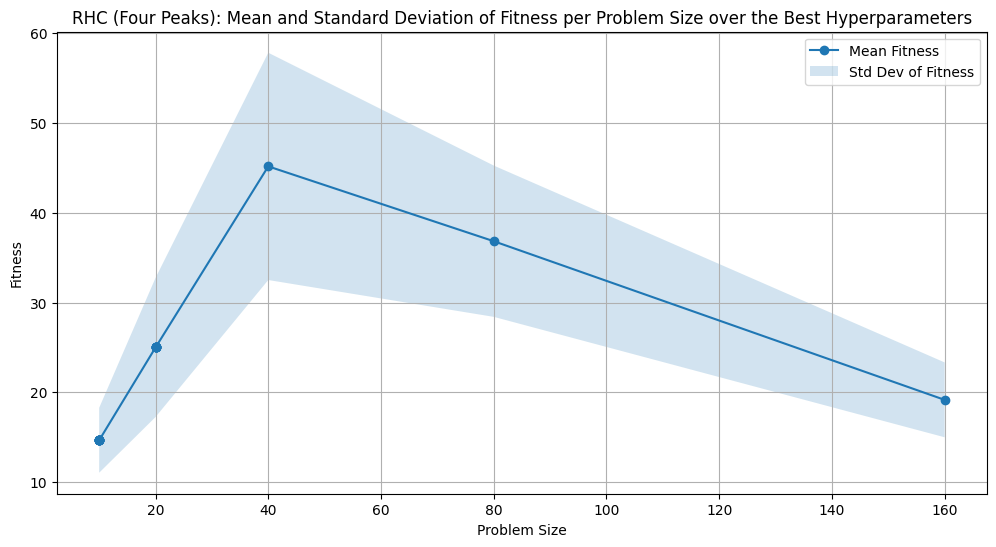

In [61]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(result_with_std['problem_size'], result_with_std['mean_Fitness'], 'o-', label='Mean Fitness')
plt.fill_between(result_with_std['problem_size'], 
                 result_with_std['mean_Fitness'] - result_with_std['std_Fitness'], 
                 result_with_std['mean_Fitness'] + result_with_std['std_Fitness'], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('RHC (Four Peaks): Mean and Standard Deviation of Fitness per Problem Size over the Best Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()